# 19. AMES HOUSING: REVISITING OUTLIERS
---

## 1. Introducing the Data

In [1]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

ames = pd.read_csv('data/Ames_Housing2_train14')
holdout = pd.read_csv('data/Ames_Housing2_test14')
print(ames.shape)
print(holdout.shape)
ames.head()

(2344, 14)
(586, 14)


,Overall Qual,Gr Liv Area,1st Flr SF,2nd Flr SF,BsmtFin SF 1,Garage Cars,Lot Area,Full Bath,Kitchen Qual,Year Built,Year Remod/Add,Bsmt Qual,Lot Frontage,SalePrice
0,7,-0.244,0.559,-0.781,-0.979,2,0.034,2,5,0.181,-0.381,7,0.469,152000.0
1,5,1.255,0.013,1.481,-0.428,2,2.307,2,5,-0.116,-0.814,5,0.410,185000.0
2,4,-0.533,0.180,-0.781,-0.979,2,-0.036,2,5,-0.280,-1.055,0,0.014,101800.0
3,4,-0.898,-0.298,-0.781,-0.979,2,-0.364,2,5,-0.709,-1.632,0,-0.441,90000.0
4,4,0.413,-0.140,0.624,-0.979,0,-0.311,2,3,-1.665,-1.632,3,-0.305,94550.0


In [2]:
X_train = ames.drop(['SalePrice'], axis=1)
y_train = ames['SalePrice']
X_test = holdout.drop(['SalePrice'], axis=1)
y_test = holdout['SalePrice']

X_train.shape, X_test.shape

((2344, 13), (586, 13))

## 2. Visualizing Outliers in the `X_train`
Since data are scaled, it actually makes it easier to visualize the outliers

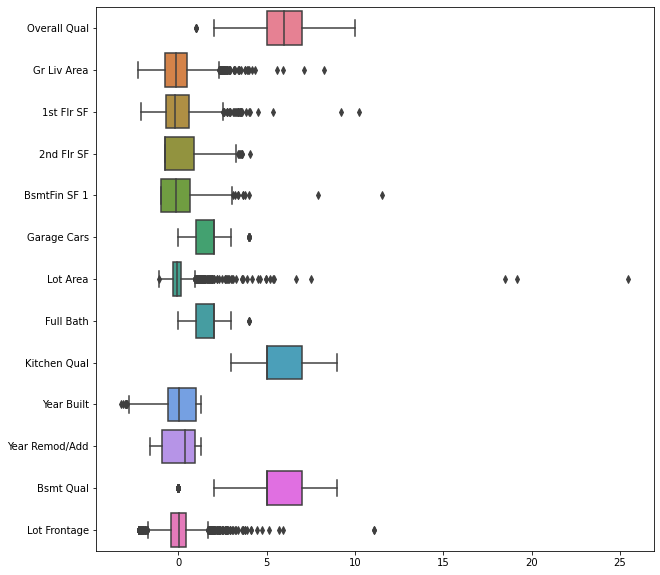

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=X_train, orient="h", palette="husl")

## 3. Capping Outliers and Visualizing the Effect

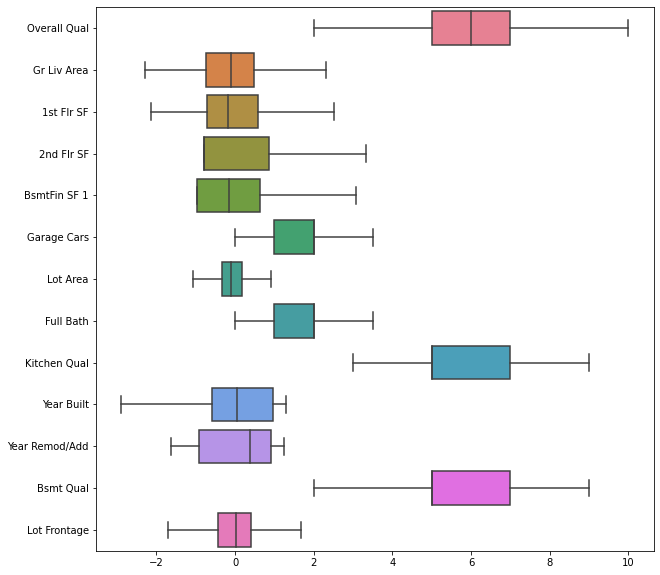

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierCapper(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self    
        
    def fit(self, df, y = None):               
        return self

    def transform(self, df):        
        df = df.copy()
        cols = df.columns
        for col in cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            LB = Q1 - (IQR * 1.5)
            UB = Q3 + (IQR * 1.5)
            df.loc[df[col] > UB, col] = UB
            df.loc[df[col] < LB, col] = LB
        return df
    
outliar = OutlierCapper()
X_train_ = outliar.fit_transform(X_train)

plt.figure(figsize=(10,10))
ax = sns.boxplot(data=X_train_, orient="h", palette="husl")

The boxplots look very clean. An interesting observation though: the features that were not scaled are the one at the higher end of the overall data range. Maybe it's too bad to scale ordinal data too!
## 4. Training Random Forest after Capping Outliers

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

ranfo = RandomForestRegressor(max_depth=8, min_samples_leaf=1,
                            min_samples_split=4)
ranfo_mse = cross_val_score(ranfo, X_train_, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [23774.12684488 30431.77691003 23605.51647563 25477.57592671
 26536.98872152 26748.21836837 35918.73953134 27399.14905024
 25757.14108672 23201.17521287]
Avg_RMSE: 26885.040812829695
Std_RMSE: 3631.09162580598


So the average RMSE goes up by a hair but the std deviation even more (almost 10%). This suggests that we need to look into our target attribute.
## 